In [1]:
%pylab inline
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import sys
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from joblib import Parallel, delayed
import multiprocessing
import pickle
import gzip

from PIL import Image


def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

Populating the interactive namespace from numpy and matplotlib


In [2]:
padresults_0 = pickle.load(gzip.open('results/pads_2.gz', 'rb'))
padresults_1 = pickle.load(gzip.open('results/pads_2.gz', 'rb'))
padresults_2 = pickle.load(gzip.open('results/pads_4.gz', 'rb'))
padresults_3 = pickle.load(gzip.open('results/pads_8.gz', 'rb'))
padresults_4 = pickle.load(gzip.open('results/pads_16.gz','rb'))
annulusresults_0 = pickle.load(gzip.open('results/annulus_1.gz','rb'))
annulusresults_1 = pickle.load(gzip.open('results/annulus_2.gz','rb'))
annulusresults_2 = pickle.load(gzip.open('results/annulus_4.gz','rb'))
annulusresults_3 = pickle.load(gzip.open('results/annulus_8.gz','rb'))
annulusresults_4 = pickle.load(gzip.open('results/annulus_16.gz','rb'))

pad_results = [padresults_0,padresults_1,padresults_2,padresults_3,padresults_4]
annulus_results = [annulusresults_0,annulusresults_1, annulusresults_2,annulusresults_3,annulusresults_4]

pad_im = Image.open('padmask.tif')
pad_imarray = np.flip(np.array(pad_im),0)

annulus_im = Image.open('annulusmask.tif')
annulus_imarray = np.flip(np.array(annulus_im),0)

annulus_mask = annulus_imarray == 0
annulus_distance = -ndimage.distance_transform_edt(annulus_mask) + ndimage.distance_transform_edt(1 - annulus_mask)
annulus_distance = annulus_distance.flatten()

pad_mask = pad_imarray == 0
pad_distance = -ndimage.distance_transform_edt(pad_mask) + ndimage.distance_transform_edt(1 - pad_mask)
pad_distance = pad_distance.flatten()

N = 160
M = 120


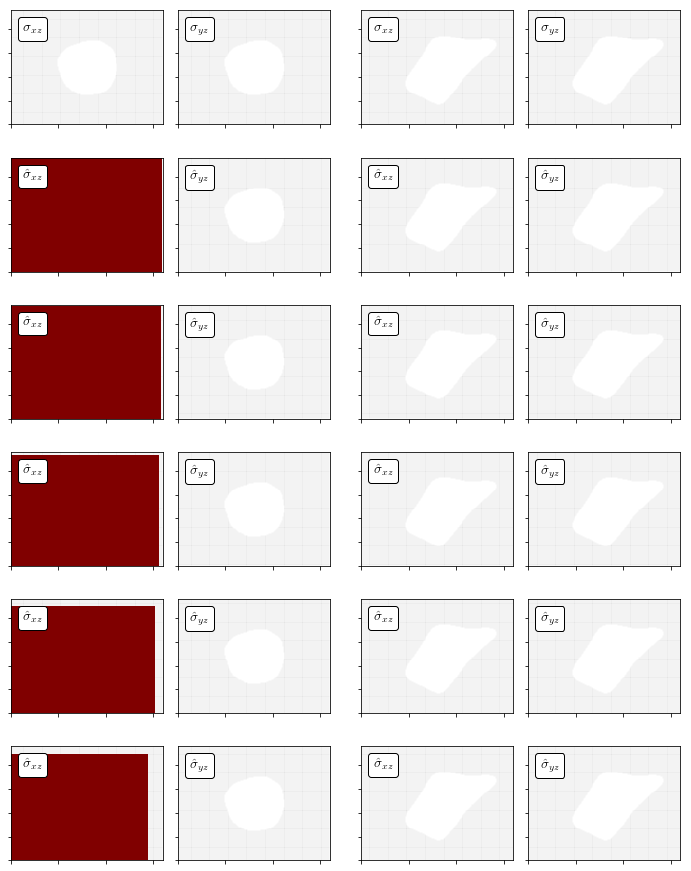

In [11]:
fig = plt.figure(figsize=(12,16))
#fig = plt.figure()
max_annulus = 5e-4
max_pads = 5e-4
gs0 = gridspec.GridSpec(1,2, hspace = 0.1,wspace=0.1)

gs_j_left = [] # just collect these here
gs_j_right = [] # just collect these here
ax = []
im = []

# left panel: annulus

J = 5

left_panel = gridspec.GridSpecFromSubplotSpec(J+1,1,
                subplot_spec=gs0[0,0],
                hspace = 0.1,wspace=0.1)

gs_j_left += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec=left_panel[0,0],
            width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
            #height_ratios = [1,1,1,1,1,1,1])]
        
ax += [plt.Subplot(fig, gs_j_left[0][0,0])]

fig.add_subplot(ax[-1])
ax[-1].pcolormesh(annulus_imarray==0,
                           cmap='gray',alpha=0.01).axes.set_aspect('equal')

ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])

at = AnchoredText("${\sigma}_{xz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax += [plt.Subplot(fig, gs_j_left[0][0,1])]
fig.add_subplot(ax[-1])
ax[-1].pcolormesh(annulus_imarray==0,
                           cmap='gray',alpha=0.01).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])

at = AnchoredText("${\sigma}_{yz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)    
    
for j in range(J):
    # Find the index of the best reconstruction
    
    data_error = [extractn(res,1) for res in annulus_results[j]][:-1]

    reg_error = [extractn(res,2) for res in annulus_results[j]][:-1]
    lvals = [extractn(res,3) for res in annulus_results[j]][:-1]

    # kill all nones

    data_error = np.array([item for item in data_error if item is not None])
    reg_error = np.array([item for item in reg_error if item is not None])
    lvals = np.array([item for item in lvals if item is not None])
    
    l_curve_distances = ((reg_error[-1]-reg_error[0])* data_error -  \
                (data_error[-1]-data_error[0])*(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])**2
    best = np.argsort(l_curve_distances)[-1]
    
    bestresult = annulus_results[j][best]
    best_s_vals_x = bestresult[0][:,0]
    best_s_vals_y = bestresult[0][:,1]
    
    xgrid = annulus_results[j][-1][0]
    ygrid = annulus_results[j][-1][1]
    
    coords = [[ [x,y] for x in xgrid] for y in ygrid] 
    coords = np.array([item for sublist in coords for item in sublist])

    # generate the conditions

    distancefun = np.array([annulus_distance.reshape((M,N))[a[1],a[0]] for a in coords]) # stupid but works
    condition_inside = distancefun<=0
    
    s_x = np.zeros(len(distancefun))
    s_y = np.zeros(len(distancefun))
    
    s_x[condition_inside].flat = bestresult[0][:,0]
    s_y[condition_inside].flat = bestresult[0][:,1]
    
    
    
    ####### Now we need to reconstruct the stress fields on a 2d grid
    # this is a pain! Should have saved the data more intelligently!
    
    gs_j_left += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=left_panel[j+1,0],
                width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
                #height_ratios = [1,1,1,1,1,1,1])]
        
    ax += [plt.Subplot(fig, gs_j_left[j+1][0,0])]
    fig.add_subplot(ax[-1])
    ax[-1].pcolormesh(annulus_imarray==0,
                           cmap='gray',alpha=0.01).axes.set_aspect('equal')
    ax[-1].pcolormesh(xgrid,ygrid,s_x.reshape(len(ygrid),len(xgrid)),
                     cmap='seismic_r')#, vmax=2e-4,vmin=-2e-4)
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    ax += [plt.Subplot(fig, gs_j_left[j+1][0,1])]
    fig.add_subplot(ax[-1])
    ax[-1].pcolormesh(annulus_imarray==0,
                           cmap='gray',alpha=0.01).axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
        
# right panel: pads

right_panel = gridspec.GridSpecFromSubplotSpec(6,1,
                subplot_spec=gs0[0,1],
                hspace = 0.1,wspace=0.1)

gs_j_right += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=right_panel[0,0],
                width_ratios = [1,1], hspace = 0.1,wspace=0.1)]

ax += [plt.Subplot(fig, gs_j_right[0][0,0])]
fig.add_subplot(ax[-1])
ax[-1].pcolormesh(pad_imarray==0,
                           cmap='gray',alpha=0.01).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])

at = AnchoredText("${\sigma}_{xz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax += [plt.Subplot(fig, gs_j_right[0][0,1])]
fig.add_subplot(ax[-1])
ax[-1].pcolormesh(pad_imarray==0,
                           cmap='gray',alpha=0.01).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])

at = AnchoredText("${\sigma}_{yz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

for j in range(J):
    gs_j_right += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=right_panel[j+1,0],
                width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
                #height_ratios = [1,1,1,1,1,1,1])]
        
    ax += [plt.Subplot(fig, gs_j_right[j+1][0,0])]
    fig.add_subplot(ax[-1])
    ax[-1].pcolormesh(pad_imarray==0,
                           cmap='gray',alpha=0.01).axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    ax += [plt.Subplot(fig, gs_j_right[j+1][0,1])]
    fig.add_subplot(ax[-1])
    ax[-1].pcolormesh(pad_imarray==0,
                           cmap='gray',alpha=0.01).axes.set_aspect('equal')
    
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
        

# left annotation

# top annotation

In [13]:
annulus_results[4][0][0]

array([[[  8.94559784e-09,  -7.00059055e-08],
        [  1.34882762e-06,  -6.10338823e-08],
        [  6.01016089e-09,  -2.53019611e-07],
        [ -1.34812363e-06,  -6.71314519e-08],
        [ -3.74026920e-07,   7.72480563e-07],
        [ -3.93610320e-08,   5.72935262e-08],
        [  3.62936784e-07,   7.09309741e-07],
        [ -5.31874536e-07,  -5.59144210e-08],
        [  5.39276170e-09,  -1.05551861e-06],
        [  5.61273197e-07,   2.35400503e-08]]])